# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import os


import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#from IPython.display import HTML
#import json
#import altair as alt

# Check Shape and Size of Data
Do work here

In [3]:
train = pd.read_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/train.csv')
test = pd.read_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/test.csv')
sub = pd.read_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/sample_submission.csv')
structure = pd.read_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/structures.csv')

In [4]:
print('train:', train.shape)
print('test:', test.shape)
print('structure:', structure.shape)

train: (4658147, 6)
test: (2505542, 5)
structure: (2358657, 6)


In [5]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [6]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [7]:
structure.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


# Check for null values and duplicate rows
Do work here

In [8]:
train.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
dtype: int64

In [9]:
structure.isna().sum()

molecule_name    0
atom_index       0
atom             0
x                0
y                0
z                0
dtype: int64

In [10]:
train[train.duplicated(subset = None, keep = 'first') == True]

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant


In [11]:
structure[structure.duplicated(subset = None, keep = 'first') == True]

,molecule_name,atom_index,atom,x,y,z


In [12]:
# combine with structures
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df
for atom_idx in [0,1]:
    train = map_atom_info(train,structure, atom_idx)
    train = train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

In [13]:
for atom_idx in [0,1]:
    test = map_atom_info(test,structure, atom_idx)
    test = test.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

In [14]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661638586,0.0,1.0,H,1.6616385860,0.0,1.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0


In [15]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958


In [16]:
test['type'].unique()

array(['2JHC', '1JHC', '3JHH', '3JHC', '2JHH', '1JHN', '3JHN', '2JHN'],
      dtype=object)

In [17]:
train['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

# Analysis - Check for distribution of target variable
Do work here

(array([2.200000e+01, 3.680000e+02, 2.448000e+04, 3.060790e+05,
        6.652030e+05, 2.343922e+06, 5.323860e+05, 2.293200e+04,
        3.793000e+03, 1.242900e+04, 1.025500e+04, 6.048000e+03,
        7.698000e+03, 1.044300e+04, 2.457000e+03, 8.599000e+03,
        1.842870e+05, 2.403080e+05, 8.699300e+04, 4.280500e+04,
        4.593600e+04, 3.815400e+04, 2.431900e+04, 1.794100e+04,
        8.623000e+03, 2.051000e+03, 3.070000e+02, 4.500000e+01,
        3.000000e+00, 1.000000e+00, 0.000000e+00, 1.280000e+02,
        6.893000e+03, 2.239000e+03]),
 array([-36.2186    , -29.12746471, -22.03632941, -14.94519412,
         -7.85405882,  -0.76292353,   6.32821176,  13.41934706,
         20.51048235,  27.60161765,  34.69275294,  41.78388824,
         48.87502353,  55.96615882,  63.05729412,  70.14842941,
         77.23956471,  84.3307    ,  91.42183529,  98.51297059,
        105.60410588, 112.69524118, 119.78637647, 126.87751176,
        133.96864706, 141.05978235, 148.15091765, 155.24205294,
  

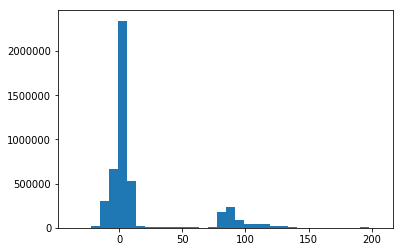

In [18]:
plt.hist(train['scalar_coupling_constant'], bins = 34)

# Feature Engineering from 'https://www.kaggle.com/kmat2019/effective-feature'
Do work here

## Calculate the distance

In [19]:
def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df
train=make_features(train)

In [20]:
test = make_features(test)

In [21]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958,-0.0148485519,1.0918354756,0.0060248754,1.091953059611900
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748,1.0095804270,1.4697824796,-0.0016995456,1.783119756038801
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152,-0.5429654850,1.4535579316,-0.8786198356,1.783147496403011
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942,-0.5259640505,1.4439639616,0.9044211738,1.783156685329616
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958,-1.0244289789,-0.3779470040,0.0077244210,1.091951618581363


In [22]:
df_temp=train.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
df_temp_=df_temp.copy()
df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                   'atom_index_1': 'atom_index_0',
                                   'x_0': 'x_1',
                                   'y_0': 'y_1',
                                   'z_0': 'z_1',
                                   'x_1': 'x_0',
                                   'y_1': 'y_0',
                                   'z_1': 'z_0'})
df_temp=pd.concat((df_temp,df_temp_),axis=0)

df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
df_temp= df_temp[df_temp["min_distance"]==df_temp["distance"]]

df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                 'atom_index_1': 'atom_index_closest',
                                 'distance': 'distance_closest',
                                 'x_1': 'x_closest',
                                 'y_1': 'y_closest',
                                 'z_1': 'z_closest'})

for atom_idx in [0,1]:
    train = map_atom_info(train,df_temp, atom_idx)
    train = train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})

In [23]:
df_temp=test.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
df_temp_=df_temp.copy()
df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                   'atom_index_1': 'atom_index_0',
                                   'x_0': 'x_1',
                                   'y_0': 'y_1',
                                   'z_0': 'z_1',
                                   'x_1': 'x_0',
                                   'y_1': 'y_0',
                                   'z_1': 'z_0'})
df_temp=pd.concat((df_temp,df_temp_),axis=0)

df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
df_temp= df_temp[df_temp["min_distance"]==df_temp["distance"]]

df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                 'atom_index_1': 'atom_index_closest',
                                 'distance': 'distance_closest',
                                 'x_1': 'x_closest',
                                 'y_1': 'y_closest',
                                 'z_1': 'z_closest'})

for atom_idx in [0,1]:
    test = map_atom_info(test,df_temp, atom_idx)
    test = test.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})

In [24]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,2.2611780778,0.0,0.0,2.2611780778,1,1.0620990942,-0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,1.0620990942,0.0,0.0,1.0620990942,1,1.0620990942,-0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661638586,0.0,1.0,H,1.6616385860,0.0,1.0,3.3232771720,0.0,0.0,3.3232771720,1,1.0620990942,-0.5995394918,0.0,1.0,0,1.0620990942,0.5995394918,0.0,1.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,-1.0620990942,0.0,0.0,1.0620990942,0,1.0620990942,0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,-2.2611780778,0.0,0.0,2.2611780778,0,1.0620990942,0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0


In [25]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df
    
train=add_cos_features(train)

In [26]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,2.2611780778,0.0,0.0,2.2611780778,1,1.0620990942,-0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,1.0620990942,0.0,0.0,1.0620990942,1,1.0620990942,-0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661638586,0.0,1.0,H,1.6616385860,0.0,1.0,3.3232771720,0.0,0.0,3.3232771720,1,1.0620990942,-0.5995394918,0.0,1.0,0,1.0620990942,0.5995394918,0.0,1.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,-1.0620990942,0.0,0.0,1.0620990942,0,1.0620990942,0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,-2.2611780778,0.0,0.0,2.2611780778,0,1.0620990942,0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0


In [27]:
test = add_cos_features(test)

In [28]:
test.isna().sum()

id                      0
molecule_name           0
atom_index_0            0
atom_index_1            0
type                    0
atom_0                  0
x_0                     0
y_0                     0
z_0                     0
atom_1                  0
x_1                     0
y_1                     0
z_1                     0
dx                      0
dy                      0
dz                      0
distance                0
atom_index_closest_0    0
distance_closest_0      0
x_closest_0             0
y_closest_0             0
z_closest_0             0
atom_index_closest_1    0
distance_closest_1      0
x_closest_1             0
y_closest_1             0
z_closest_1             0
distance_0              0
distance_1              0
cos_0_1                 0
cos_0                   0
cos_1                   0
dtype: int64

In [29]:
train.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
dx                          0
dy                          0
dz                          0
distance                    0
atom_index_closest_0        0
distance_closest_0          0
x_closest_0                 0
y_closest_0                 0
z_closest_0                 0
atom_index_closest_1        0
distance_closest_1          0
x_closest_1                 0
y_closest_1                 0
z_closest_1                 0
distance_0                  0
distance_1                  0
cos_0_1                     0
cos_0                       0
cos_1                       0
dtype: int

# XG Boost Model

In [30]:
import xgboost

In [31]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958,-0.0148485519,1.0918354756,0.0060248754,1.091953059611900,0,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,3,1.091946379133103,-0.5408150690,1.447526614,-0.8766437152,1.091953059611900,1.091946379133103,0.333334935854766,-1.000000000000000,-0.333334935854766
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748,1.0095804270,1.4697824796,-0.0016995456,1.783119756038801,0,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,0,1.091951618581363,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,1.091951618581363,-0.333287053439111,-0.816482679941363,0.816482141136433
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152,-0.5429654850,1.4535579316,-0.8786198356,1.783147496403011,0,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,0,1.091946379133103,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,1.091946379133103,-0.333334935854766,-0.816498320410405,0.816495822780885
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942,-0.5259640505,1.4439639616,0.9044211738,1.783156685329616,0,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,0,1.091947541112027,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,1.091947541112027,-0.333347258933468,-0.816501876318066,0.816499813166186
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958,-1.0244289789,-0.3779470040,0.0077244210,1.091951618581363,0,1.091951618581363,-0.0126981359,1.085804158,0.0080009958,3,1.091946379133103,-0.5408150690,1.447526614,-0.8766437152,1.091951618581363,1.091946379133103,0.333351894767600,-1.000000000000000,-0.333351894767600


In [32]:
train = pd.get_dummies(train, columns = ['atom_index_0', 'atom_index_1', 'atom_1', 'atom_0'
                                         ,'atom_index_closest_0', 'atom_index_closest_1'])
test = pd.get_dummies(test, columns = ['atom_index_0', 'atom_index_1', 'atom_1', 'atom_0'
                                         ,'atom_index_closest_0', 'atom_index_closest_1'])


In [33]:
train.drop(['atom_index_closest_0_12', 'atom_index_closest_0_18', 'atom_index_closest_0_14'
                     , 'atom_index_0_0'], axis = 1, inplace =  True)

In [34]:
train.head()

,id,molecule_name,type,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,atom_index_0_1,atom_index_0_2,atom_index_0_3,atom_index_0_4,atom_index_0_5,atom_index_0_6,atom_index_0_7,atom_index_0_8,atom_index_0_9,atom_index_0_10,atom_index_0_11,atom_index_0_12,atom_index_0_13,atom_index_0_14,atom_index_0_15,atom_index_0_16,atom_index_0_17,atom_index_0_18,atom_index_0_19,atom_index_0_20,atom_index_0_21,atom_index_0_22,atom_index_0_23,...,atom_index_1_24,atom_index_1_25,atom_index_1_26,atom_index_1_27,atom_index_1_28,atom_1_C,atom_1_H,atom_1_N,atom_0_H,atom_index_closest_0_0,atom_index_closest_0_1,atom_index_closest_0_2,atom_index_closest_0_3,atom_index_closest_0_4,atom_index_closest_0_5,atom_index_closest_0_6,atom_index_closest_0_7,atom_index_closest_0_8,atom_index_closest_0_9,atom_index_closest_0_10,atom_index_closest_0_11,atom_index_closest_1_0,atom_index_closest_1_1,atom_index_closest_1_2,atom_index_closest_1_3,atom_index_closest_1_4,atom_index_closest_1_5,atom_index_closest_1_6,atom_index_closest_1_7,atom_index_closest_1_8,atom_index_closest_1_9,atom_index_closest_1_10,atom_index_closest_1_11,atom_index_closest_1_12,atom_index_closest_1_13,atom_index_closest_1_14,atom_index_closest_1_15,atom_index_closest_1_16,atom_index_closest_1_17,atom_index_closest_1_18,atom_index_closest_1_19,atom_index_closest_1_20,atom_index_closest_1_21,atom_index_closest_1_22,atom_index_closest_1_23,atom_index_closest_1_24,atom_index_closest_1_25,atom_index_closest_1_26,atom_index_closest_1_27,atom_index_closest_1_28
0,0,dsgdb9nsd_000001,1JHC,84.807599999999994,0.002150416,-0.0060313176,0.0019761204,-0.0126981359,1.085804158,0.0080009958,-0.0148485519,1.0918354756,0.0060248754,1.091953059611900,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,1.091946379133103,-0.5408150690,1.447526614,-0.8766437152,1.091953059611900,1.091946379133103,0.333334935854766,-1.000000000000000,-0.333334935854766,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,dsgdb9nsd_000001,2JHH,-11.257000000000000,0.002150416,-0.0060313176,0.0019761204,1.0117308430,1.463751162,0.0002765748,1.0095804270,1.4697824796,-0.0016995456,1.783119756038801,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,1.091951618581363,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,1.091951618581363,-0.333287053439111,-0.816482679941363,0.816482141136433,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,dsgdb9nsd_000001,2JHH,-11.254799999999999,0.002150416,-0.0060313176,0.0019761204,-0.5408150690,1.447526614,-0.8766437152,-0.5429654850,1.4535579316,-0.8786198356,1.783147496403011,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,1.091946379133103,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,1.091946379133103,-0.333334935854766,-0.816498320410405,0.816495822780885,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,dsgdb9nsd_000001,2JHH,-11.254300000000001,0.002150416,-0.0060313176,0.0019761204,-0.5238136345,1.437932644,0.9063972942,-0.5259640505,1.4439639616,0.9044211738,1.783156685329616,1.091953059611900,-0.0126981359,1.085804158,0.0080009958,1.091947541112027,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,1.091947541112027,-0.333347258933468,-0.816501876318066,0.816499813166186,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,dsgdb9nsd_000001,1JHC,84.807400000000001,1.011730843,1.4637511620,0.0002765748,-0.0126981359,1.085804158,0.0080009958,-1.0244289789,-0.3779470040,0.0077244210

In [35]:
test.head()

,id,molecule_name,type,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,atom_index_0_1,atom_index_0_2,atom_index_0_3,atom_index_0_4,atom_index_0_5,atom_index_0_6,atom_index_0_7,atom_index_0_8,atom_index_0_9,atom_index_0_10,atom_index_0_11,atom_index_0_12,atom_index_0_13,atom_index_0_14,atom_index_0_15,atom_index_0_16,atom_index_0_17,atom_index_0_18,atom_index_0_19,atom_index_0_20,atom_index_0_21,atom_index_0_22,atom_index_0_23,atom_index_0_24,...,atom_index_1_24,atom_index_1_25,atom_index_1_26,atom_index_1_27,atom_index_1_28,atom_1_C,atom_1_H,atom_1_N,atom_0_H,atom_index_closest_0_0,atom_index_closest_0_1,atom_index_closest_0_2,atom_index_closest_0_3,atom_index_closest_0_4,atom_index_closest_0_5,atom_index_closest_0_6,atom_index_closest_0_7,atom_index_closest_0_8,atom_index_closest_0_9,atom_index_closest_0_10,atom_index_closest_0_11,atom_index_closest_1_0,atom_index_closest_1_1,atom_index_closest_1_2,atom_index_closest_1_3,atom_index_closest_1_4,atom_index_closest_1_5,atom_index_closest_1_6,atom_index_closest_1_7,atom_index_closest_1_8,atom_index_closest_1_9,atom_index_closest_1_10,atom_index_closest_1_11,atom_index_closest_1_12,atom_index_closest_1_13,atom_index_closest_1_14,atom_index_closest_1_15,atom_index_closest_1_16,atom_index_closest_1_17,atom_index_closest_1_18,atom_index_closest_1_19,atom_index_closest_1_20,atom_index_closest_1_21,atom_index_closest_1_22,atom_index_closest_1_23,atom_index_closest_1_24,atom_index_closest_1_25,atom_index_closest_1_26,atom_index_closest_1_27,atom_index_closest_1_28
0,4658147,dsgdb9nsd_000004,2JHC,-1.661638586,0.0,1.0,0.5995394918,0.0,1.0,2.2611780778,0.0,0.0,2.2611780778,1.0620990942,-0.5995394918,0.0,1.0,1.0620990942,1.6616385860,0.0,1.0,1.0620990942,1.0620990942,1.0,-1.0,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4658148,dsgdb9nsd_000004,1JHC,-1.661638586,0.0,1.0,-0.5995394918,0.0,1.0,1.0620990942,0.0,0.0,1.0620990942,1.0620990942,-0.5995394918,0.0,1.0,1.0620990942,-1.6616385860,0.0,1.0,1.0620990942,1.0620990942,-1.0,-1.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4658149,dsgdb9nsd_000004,3JHH,-1.661638586,0.0,1.0,1.6616385860,0.0,1.0,3.3232771720,0.0,0.0,3.3232771720,1.0620990942,-0.5995394918,0.0,1.0,1.0620990942,0.5995394918,0.0,1.0,1.0620990942,1.0620990942,-1.0,-1.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4658150,dsgdb9nsd_000004,1JHC,1.661638586,0.0,1.0,0.5995394918,0.0,1.0,-1.0620990942,0.0,0.0,1.0620990942,1.0620990942,0.5995394918,0.0,1.0,1.0620990942,1.6616385860,0.0,1.0,1.0620990942,1.0620990942,-1.0,-1.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4658151,dsgdb9nsd_000004,2JHC,1.661638586,0.0,1.0,-0.5995394918,0.0,1.0,-2.2611780778,0.0,0.0,2.2611780778,1.0620990942,0.5995394918,0.0,1.0,1.0620990942,-1.6616385860,0.0,1.0,1.0620990942,1.0620990942,1.0,-1.0,-1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
y_train = train['scalar_coupling_constant']
x_train = train.iloc[:, 4:]
x_test = test.iloc[:, 3:]

In [37]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test)

In [ ]:
depths = [10, 15, 20]
num_rounds = [15, 20, 25]

for depth in depths:
    for round in num_rounds:
        NAME = "{}-depth-round{}-{}-time".format(depth, round, int(time.time()))
        print(NAME)

        # specify parameters via map
        param = {'max_depth':depth, 'eta':1, 'silent':1, 'objective':'reg:linear' }
        param['eval_metric'] = 'mae'
        num_round = round
        bst = xgb.train(param, dtrain, num_round)
        # make prediction
        preds = bst.predict(dtest)
        benchmark = sub.copy()
        benchmark['scalar_coupling_constant'] = preds
        benchmark.to_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/'+NAME+'.csv', index=False)


10-depth-round15-1561317340-time
[15:15:40] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
10-depth-round20-1561317570-time
[15:19:30] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


# Fast AI Modeling
Do work here

In [30]:
from fastai.tabular import *

In [108]:
train

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.0021504160,-0.0060313176,0.0019761204,C,-0.0126981359,1.0858041580,0.0080009958,-0.0148485519,1.0918354756,0.0060248754,1.091953059611900,0,1.091953059611900,-0.0126981359,1.0858041580,0.0080009958,3,1.091946379133103,-0.5408150690,1.4475266140,-0.8766437152,1.091953059611900,1.091946379133103,0.333334935854766,-1.000000000000000,-0.333334935854766
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.0021504160,-0.0060313176,0.0019761204,H,1.0117308430,1.4637511620,0.0002765748,1.0095804270,1.4697824796,-0.0016995456,1.783119756038801,0,1.091953059611900,-0.0126981359,1.0858041580,0.0080009958,0,1.091951618581363,-0.0126981359,1.0858041580,0.0080009958,1.091953059611900,1.091951618581363,-0.333287053439111,-0.816482679941363,0.816482141136433
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.0021504160,-0.0060313176,0.0019761204,H,-0.5408150690,1.4475266140,-0.8766437152,-0.5429654850,1.4535579316,-0.8786198356,1.783147496403011,0,1.091953059611900,-0.0126981359,1.0858041580,0.0080009958,0,1.091946379133103,-0.0126981359,1.0858041580,0.0080009958,1.091953059611900,1.091946379133103,-0.333334935854766,-0.816498320410405,0.816495822780885
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.0021504160,-0.0060313176,0.0019761204,H,-0.5238136345,1.4379326440,0.9063972942,-0.5259640505,1.4439639616,0.9044211738,1.783156685329616,0,1.091953059611900,-0.0126981359,1.0858041580,0.0080009958,0,1.091947541112027,-0.0126981359,1.0858041580,0.0080009958,1.091953059611900,1.091947541112027,-0.333347258933468,-0.816501876318066,0.816499813166186
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.0117308430,1.4637511620,0.0002765748,C,-0.0126981359,1.0858041580,0.0080009958,-1.0244289789,-0.3779470040,0.0077244210,1.091951618581363,0,1.091951618581363,-0.0126981359,1.0858041580,0.0080009958,3,1.091946379133103,-0.5408150690,1.4475266140,-0.8766437152,1.091951618581363,1.091946379133103,0.333351894767600,-1.000000000000000,-0.333351894767600
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.254099999999999,H,1.0117308430,1.4637511620,0.0002765748,H,-0.5408150690,1.4475266140,-0.8766437152,-1.5525459120,-0.0162245480,-0.8769202900,1.783157659838131,0,1.091951618581363,-0.0126981359,1.0858041580,0.0080009958,0,1.091946379133103,-0.0126981359,1.0858041580,0.0080009958,1.091951618581363,1.091946379133103,-0.333351894767600,-0.816503243567464,0.816501284756792
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.254799999999999,H,1.0117308430,1.4637511620,0.0002765748,H,-0.5238136345,1.4379326440,0.9063972942,-1.5355444775,-0.0258185180,0.9061207194,1.783148394379570,0,1.091951618581363,-0.0126981359,1.0858041580,0.0080009958,0,1.091947541112027,-0.0126981359,1.0858041580,0.0080009958,1.091951618581363,1.091947541112027,-0.333336619508129,-0.816498349326916,0.816496824888737
7,7,dsgdb9nsd_000001,3,0,1JHC,84.809299999999993,H,-0.5408150690,1.4475266140,-0.8766437152,C,-0.0126981359,1.0858041580,0.0080009958,0.5281169331,-0.3617224560,0.8846447110,1.091946379133103,0,1.091946379133103,-0.0126981359,1.0858041580,0.0080009958,3,1.091946379133103,-0.5408150690,1.4475266140,-0.8766437152,1.091946379133103,1.091946379133103,-1.000000000000000,-1.000000000000000,1.000000000000000
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.254300000000001,H,-0.5408150690,1.4475266140,-0.8766437152,H,-0.5238136345,1.4379326440,0.9063972942,0.0170014345,-0.0095939700,1.7830410094,1.783147872229780,0,1.091946379133103,-0.0126981359,1.0858041580,0.0080009958,0,1.091947541112027,-0.0126981359,1.0858041580,0.0080009958,1.091946379133103,1.091947541112027,-0.333342236345903,-0.816499089690853,0.816499524114875
9,9,dsgdb9nsd_000001,4,0,1JHC,84.80

In [109]:
dep_var = 'scalar_coupling_constant'

cat_names = ['type', 'atom_1', 'atom_0', 'atom_index_closest_0','atom_index_closest_1']

cont_names = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'dx', 'dy', 'dz', 'distance', 'x_closest_0', 'y_closest_0'
              , 'z_closest_0', 'distance_closest_1', 'x_closest_1', 'y_closest_1', 'z_closest_1','distance_0'
              , 'distance_1', 'cos_0_1', 'cos_0', 'cos_1']

procs = [Categorify, Normalize]

In [110]:
te = test.drop(['id', 'molecule_name'], axis=1)
test_data = TabularList.from_df(te, cat_names=cat_names, cont_names = cont_names, procs = procs)

In [111]:
tr = train.drop(['id', 'molecule_name'], axis=1)
idx = np.random.randint(0, len(tr), size=np.int(.2*len(tr)))

In [112]:

bs = 4096
data = (TabularList.from_df(tr, cat_names=cat_names, cont_names = cont_names, procs = procs)
         .split_by_idx(idx)
        .label_from_df(cols=dep_var)
        .add_test(test_data)
        .databunch(bs=bs))

In [113]:
data.show_batch(rows = 10)

type,atom_1,atom_0,atom_index_closest_0,atom_index_closest_1,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,target
2JHC,C,H,8,14,0.8029,-0.9976,0.2968,0.4321,-0.0490,0.9561,-0.5514,1.3643,0.5337,-0.2813,0.4850,-0.9839,1.0048,1.4802,1.4247,0.0914,1.3182,-0.1036,1.4802,-0.3216,0.1321,-0.0408,-1.33024
2JHC,C,H,2,9,-0.4152,0.4390,1.2504,-0.0468,0.1873,-0.0114,0.4714,-0.4035,-1.4288,-0.2325,-0.2152,0.0131,1.2668,-0.4871,0.4584,-0.1439,-0.2261,-0.1181,-0.4871,1.6026,0.0601,-1.2410,-4.42467
1JHC,C,H,4,15,-0.2612,-1.7488,-0.5138,-0.2010,-1.4239,-0.3841,0.1156,0.8025,0.2331,-1.7272,-0.2110,-1.4744,-0.3891,-0.5002,0.3699,-1.0301,-0.5293,-0.1569,-0.5002,0.8515,-1.2155,-0.8059,112.738
3JHH,H,H,1,6,0.3288,-0.2209,-0.4575,-1.2245,-0.5140,-0.6839,-1.7036,-0.2955,-0.1037,0.1598,-0.0361,0.0997,-0.0911,-0.4979,-0.9000,-0.0858,-0.0685,-0.1238,-0.4979,1.2055,1.8809,0.5567,5.22038
2JHC,C,H,1,14,-0.6382,-0.0599,-0.0216,0.4659,-0.0597,-1.0428,1.2917,0.0145,-0.9248,-0.2223,-0.0677,0.1521,-0.0702,-0.4895,0.3953,0.2755,-1.4284,-0.1068,-0.4895,0.5194,0.0075,-0.7461,0.900484
2JHC,C,H,1,9,-0.5697,-0.1227,-0.0890,-0.1621,1.0796,-0.0636,0.5436,1.4573,0.0430,-0.3100,-0.0148,0.1288,-0.0266,-0.4885,0.3859,1.2328,0.1382,-0.0933,-0.4885,1.7752,0.1570,-1.3699,-0.422725
3JHC,C,H,8,12,-0.4364,-0.2692,-0.3644,1.2034,0.3658,0.7666,1.8163,0.8184,1.1113,1.0832,-0.1056,0.0325,0.0509,-0.4881,1.5883,0.0336,0.5194,-0.1875,-0.4881,0.2644,-0.8992,-0.7851,4.79341
3JHC,C,H,4,15,0.2184,1.8445,-0.9706,1.5684,1.4597,0.0826,1.3799,-0.8964,1.1762,0.8047,0.3268,2.0460,-0.3818,-0.5129,1.7696,0.8837,0.2548,-0.0760,-0.5129,0.8476,0.3432,-1.5812,3.49211
3JHC,C,H,5,12,-1.0593,0.1992,1.3811,-1.0162,-0.9620,0.0410,0.2570,-1.4267,-1.5294,1.0295,-1.4176,-0.2208,1.2229,-0.5119,-0.6405,-1.2110,-0.4250,-0.1663,-0.5119,1.5499,-1.0206,-1.6391,5.38027
2JHC,C,H,6,19,-0.4549,1.5947,-0.1660,-0.2991,3.2252,0.1185,0.2551,1.5567,0.2962,-0.2008,-0.0778,2.2384,0.1907,-0.5087,-0.7699,2.9918,-0.2695,-0.1957,-0.5087,-0.8205,-0.1498,-0.1955,-0.576816


In [114]:
data.show_batch(rows=5, ds_type=DatasetType.Valid)

type,atom_1,atom_0,atom_index_closest_0,atom_index_closest_1,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,target
3JHC,C,H,6,12,-0.9703,-1.7724,1.0020,-1.1074,-0.6377,-0.2346,0.0492,1.7699,-1.3502,0.9575,-1.8273,-1.9651,0.8143,1.8857,-0.0881,-1.0277,-1.0020,-0.1184,1.8857,-0.4309,1.7045,-0.1678,1.64669
2JHH,H,H,0,0,-0.0897,1.0118,-0.6717,-0.6660,1.3213,0.3773,-0.5898,0.1266,1.1055,-0.8078,-0.0844,0.9742,-0.0385,-0.4793,-0.0657,0.9587,-0.0277,-0.1164,-0.4793,-0.3483,-0.2266,1.1142,-12.5602
2JHC,C,H,2,15,0.3391,-0.2166,-1.4550,1.3301,0.1300,-0.3285,0.9772,0.4633,1.3514,0.0387,0.5087,-0.2128,-1.0016,-0.4978,1.3311,0.6321,-0.2705,-0.0943,-0.4978,0.2650,-0.5298,-0.6864,1.06113
3JHC,C,H,5,10,-0.1142,0.0156,1.3576,-0.0354,1.0863,0.0150,0.1058,1.2679,-1.5263,0.4511,0.2261,-0.2519,1.0667,-0.4826,-0.4558,1.1671,-0.4388,-0.0863,-0.4826,0.1196,2.2855,-1.2418,4.76127
3JHC,C,H,0,13,0.4491,1.0379,0.0760,0.4747,-0.0519,-1.0172,-0.0627,-1.5417,-1.0123,0.6285,-0.1418,0.9809,-0.0068,-0.5066,0.2850,0.1021,-1.5092,-0.1246,-0.5066,0.4246,1.6953,-0.4679,1.30789


In [115]:
data.show_batch(rows=5, ds_type=DatasetType.Test)

type,atom_1,atom_0,atom_index_closest_0,atom_index_closest_1,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,target
2JHC,C,H,1,3,-1.0047,0.1037,0.6089,0.3393,0.2238,0.7345,1.6179,0.1180,-0.0220,-0.1355,-0.4899,0.1284,0.7776,-0.5589,0.9228,0.1903,0.6245,-0.3641,-0.5589,1.8008,-1.2155,-1.6999,0
1JHC,C,H,1,2,-1.0047,0.1037,0.6089,-0.4712,0.2238,0.7345,0.7632,0.1180,-0.0220,-1.7631,-0.4899,0.1284,0.7776,-0.5589,-1.0325,0.1903,0.6245,-0.3641,-0.5589,-1.5069,-1.2155,1.4153,0
3JHH,H,H,1,0,-1.0047,0.1037,0.6089,1.0573,0.2238,0.7345,2.3750,0.1180,-0.0220,1.3062,-0.4899,0.1284,0.7776,-0.5589,0.2979,0.1903,0.6245,-0.3641,-0.5589,-1.5069,-1.2155,1.4153,0
1JHC,C,H,0,3,0.8841,0.1037,0.6089,0.3393,0.2238,0.7345,-0.7510,0.1180,-0.0220,-1.7631,0.3466,0.1284,0.7776,-0.5589,0.9228,0.1903,0.6245,-0.3641,-0.5589,-1.5069,-1.2155,1.4153,0
2JHC,C,H,0,2,0.8841,0.1037,0.6089,-0.4712,0.2238,0.7345,-1.6057,0.1180,-0.0220,-0.1355,0.3466,0.1284,0.7776,-0.5589,-1.0325,0.1903,0.6245,-0.3641,-0.5589,1.8008,-1.2155,-1.6999,0


In [39]:
def mean_absolute_error_fastai(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Mean absolute error between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    return F.l1_loss(pred, targ)

In [40]:
learn = tabular_learner(data, 
                        layers=[1000,500,100], 
                        emb_drop=0.04,
                        ps=(0.001, 0.01, 0.1),
                        metrics=[mean_absolute_error_fastai, rmse], 
                        wd=1e-2).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


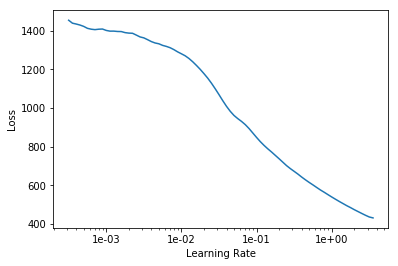

In [41]:
lr_find(learn, start_lr=1e-4, end_lr=10, num_it=100) #, start_lr=1e-2, end_lr=10, num_it=200
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(1, 1e-005)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,1291.112061,1294.271240,17.711863,35.969086,00:56


In [47]:
learn2 = tabular_learner(data, 
                        layers=[128,128,64,64,32,1], 
                        emb_drop=0.04,
                        ps=(0.01, 0.01, 0.001,.01, .01, .1),
                        metrics=[mean_absolute_error_fastai, rmse], 
                        wd=1e-2).to_fp16()

In [49]:
learn2.fit_one_cycle(10, 1e-01)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,26.974607,10.958025,1.970057,3.307999,00:56
1,27.279255,33.900230,3.531059,5.820262,00:58
2,26.134556,59.354465,6.197733,7.703115,01:00
3,26.570189,261.780151,12.563316,16.177603,00:58
4,26.548611,28.215197,3.991840,5.309852,00:59
5,24.452442,88.124687,5.761513,9.385496,00:59
6,24.831675,22.670300,3.754348,4.760106,01:00
7,24.353596,11.089443,2.125375,3.327903,01:00
8,22.400082,9.299696,1.649023,3.046774,00:59
9,22.408558,8.630789,1.602503,2.935222,01:04


In [71]:
c

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


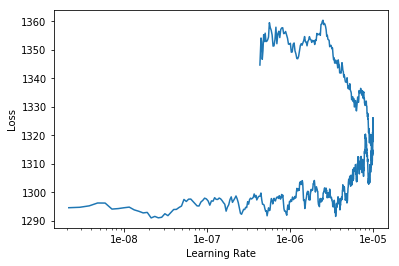

In [74]:
lr_find(learn3, start_lr=1e-04, end_lr=1, num_it=100) #, start_lr=1e-2, end_lr=10, num_it=200
learn.recorder.plot()

In [75]:
learn3.fit_one_cycle(10, 1e-01)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,185.670700,85.406059,5.238961,9.228119,01:02
1,173.491333,97.253204,6.962991,9.851547,01:02
2,177.444489,1783.127441,39.795193,42.226730,01:02
3,143.427551,nan,nan,nan,01:02
4,138.123367,36.903080,4.519921,6.072987,01:03
5,132.351471,36.305950,3.929718,6.023257,01:03
6,135.914856,26.748396,3.824364,5.170242,01:03
7,131.451279,20.158428,2.390496,4.486666,01:04
8,133.333130,15.520378,2.538588,3.937223,01:02
9,132.568756,21.425291,2.916001,4.626606,01:03


In [81]:
learn4 = tabular_learner(data, 
                        layers=[1000,500,64], 
                        emb_drop=0.04,
                        ps=(0.001, 0.01, .1),
                        metrics=[mean_absolute_error_fastai, rmse], 
                        wd=1e-2).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


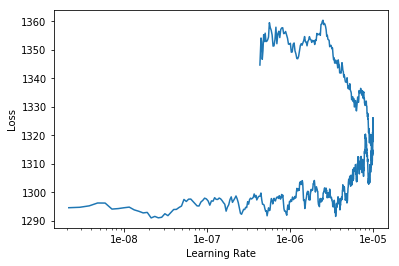

In [83]:
lr_find(learn4, start_lr=1e-04, end_lr=1, num_it=100) #, start_lr=1e-2, end_lr=10, num_it=200
learn.recorder.plot()

In [84]:
learn4.fit_one_cycle(100, 1e-001)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,12.936855,9.358681,1.769941,3.056841,01:02
1,12.458220,10.293472,2.119525,3.204960,01:02
2,12.498960,9.488076,1.701886,3.077739,01:02
3,12.608300,9.498827,1.736826,3.079484,01:01
4,12.736717,10.214194,1.872998,3.192846,01:02
5,12.542836,13.212002,2.749870,3.633331,01:02
6,13.038253,13.496329,2.576544,3.671802,01:03
7,12.723484,9.729390,1.804454,3.117306,01:01
8,13.104228,9.770746,1.877689,3.123942,01:02
9,13.163906,17.594585,2.448014,4.190863,01:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


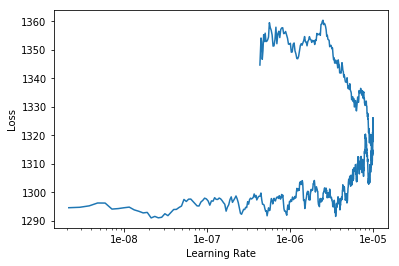

In [88]:
learn5 = tabular_learner(data, 
                        layers=[128,128,64], 
                        emb_drop=0.04,
                        ps=(0.001, 0.01, .1),
                        metrics=[mean_absolute_error_fastai, rmse], 
                        wd=1e-2).to_fp16()
lr_find(learn5, start_lr=1e-4, end_lr=10, num_it=100) #, start_lr=1e-2, end_lr=10, num_it=200
learn.recorder.plot


In [89]:
learn5.fit_one_cycle(100, 1e-01)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,16.048338,11.821783,2.023681,3.435637,01:02
1,14.921835,11.787096,2.077700,3.431474,01:03
2,14.178352,10.520666,1.935584,3.241400,01:02
3,14.538264,10.617840,1.935177,3.256173,01:03
4,14.357441,11.661267,2.024635,3.412928,01:02
5,14.237389,12.100293,2.055993,3.476879,01:02
6,15.183517,15.071079,2.772902,3.880860,01:04
7,14.431414,21.831436,3.099139,4.671257,01:04
8,13.855408,11.232943,2.067231,3.349911,01:03
9,14.264993,14.760024,2.294147,3.840603,01:02


In [94]:
learn6 = tabular_learner(data, 
                        layers=[200,100], 
                        #emb_drop=0.04,
                        #ps=(0.001, 0.01, .1),
                        metrics=[mean_absolute_error_fastai, rmse]).to_fp16()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<bound method Recorder.plot of Recorder
learn: Learner(data=TabularDataBunch;

Train: LabelList (3813514 items)
x: TabularList
type 2JHH; atom_index_closest_0 0; atom_index_closest_1 0; x_0 -0.0587; y_0 0.1012; z_0 -0.0285; x_1 0.6179; y_1 1.0523; z_1 -0.0616; dx 0.7257; dy 1.1051; dz -0.0238; distance -0.7844; x_closest_0 -0.0801; y_closest_0 0.7264; z_closest_0 -0.0459; distance_closest_1 -0.4906; x_closest_1 -0.0622; y_closest_1 0.7332; z_closest_1 -0.0340; distance_0 -0.1299; distance_1 -0.4906; cos_0_1 -0.4045; cos_0 -0.2831; cos_1 1.1297; ,type 2JHH; atom_index_closest_0 0; atom_index_closest_1 0; x_0 -0.0587; y_0 0.1012; z_0 -0.0285; x_1 -0.4311; y_1 1.0431; z_1 -0.7601; dx -0.3811; dy 1.0942; dz -0.6595; distance -0.7844; x_closest_0 -0.0801; y_closest_0 0.7264; z_closest_0 -0.0459; distance_closest_1 -0.4906; x_closest_1 -0.0622; y_closest_1 0.7332; z_closest_1 -0.0340; distance_0 -0.1299; distance_1 -0.4906; cos_0_1 -0.4046; cos_0 -0.2832; cos_1 1.1297; ,type 1JHC; atom_index

In [97]:
lr_find(learn6, start_lr=1e-4, end_lr=10, num_it=100) #, start_lr=1e-2, end_lr=10, num_it=200

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<bound method Recorder.plot of Recorder
learn: Learner(data=TabularDataBunch;

Train: LabelList (3813514 items)
x: TabularList
type 2JHH; atom_index_closest_0 0; atom_index_closest_1 0; x_0 -0.0587; y_0 0.1012; z_0 -0.0285; x_1 0.6179; y_1 1.0523; z_1 -0.0616; dx 0.7257; dy 1.1051; dz -0.0238; distance -0.7844; x_closest_0 -0.0801; y_closest_0 0.7264; z_closest_0 -0.0459; distance_closest_1 -0.4906; x_closest_1 -0.0622; y_closest_1 0.7332; z_closest_1 -0.0340; distance_0 -0.1299; distance_1 -0.4906; cos_0_1 -0.4045; cos_0 -0.2831; cos_1 1.1297; ,type 2JHH; atom_index_closest_0 0; atom_index_closest_1 0; x_0 -0.0587; y_0 0.1012; z_0 -0.0285; x_1 -0.4311; y_1 1.0431; z_1 -0.7601; dx -0.3811; dy 1.0942; dz -0.6595; distance -0.7844; x_closest_0 -0.0801; y_closest_0 0.7264; z_closest_0 -0.0459; distance_closest_1 -0.4906; x_closest_1 -0.0622; y_closest_1 0.7332; z_closest_1 -0.0340; distance_0 -0.1299; distance_1 -0.4906; cos_0_1 -0.4046; cos_0 -0.2832; cos_1 1.1297; ,type 1JHC; atom_index

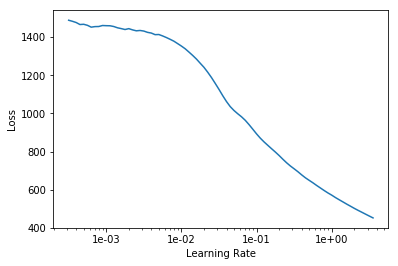

In [99]:
learn6.recorder.plot()

In [100]:
learn6.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,31.580770,18.223064,2.533879,4.265854,01:02
1,16.337242,14.465045,2.285008,3.800974,01:03
2,14.326089,12.512300,2.164706,3.535163,01:03
3,13.465093,12.488603,2.183766,3.532235,01:04
4,12.518327,11.966125,2.093561,3.457035,01:03
5,12.310315,12.045319,2.212758,3.468677,01:02
6,11.705096,11.188846,2.046300,3.343226,01:04
7,11.919374,11.797943,2.268421,3.433320,01:03
8,12.048725,11.624121,2.114463,3.407555,01:04
9,11.645649,14.503612,2.396578,3.807141,01:03


In [116]:
learn7 = tabular_learner(data, 
                        layers=[1000, 600, 400, 200,100], 
                        #emb_drop=0.04,
                        #ps=(0.001, 0.01, .1),
                        metrics=[mean_absolute_error_fastai, rmse]).to_fp16()

In [117]:
lr_find(learn7, start_lr=1e-4, end_lr=10, num_it=100) #, start_lr=1e-2, end_lr=10, num_it=200

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


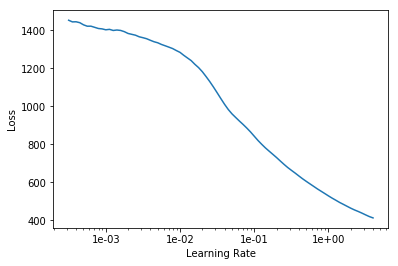

In [104]:
learn7.recorder.plot()

In [118]:
learn7.fit_one_cycle(50, 1e-1)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,11.597210,17.187683,2.300366,4.142902,01:08
1,10.810071,10.801713,1.878835,3.284032,01:08
2,10.158287,11.382866,1.979884,3.371236,01:09
3,10.503627,12.656072,2.178644,3.555326,01:09
4,11.033463,nan,nan,nan,01:10
5,10.745811,36.837936,3.228631,6.067581,01:10
6,12.196445,nan,nan,nan,01:09
7,11.514666,nan,nan,nan,01:10
8,11.095226,nan,nan,nan,01:09
9,11.412449,14.716124,2.383316,3.833071,01:10


# Check metrics

In [52]:
val_preds = learn2.get_preds(DatasetType.Valid)
y_true = tr.iloc[idx].scalar_coupling_constant
y_preds = val_preds[0][:,0].numpy()
types = tr.iloc[idx].type

# Results
Show graphs and stats here

In [69]:
maes = []
for t in types.unique():
    y_t = pd.Series(y_true[types==t])
    y_p = pd.Series(y_preds[types==t])
    
    #mae = np.log(mean_absolute_error(y_t, y_p))
    #maes.append(mae)

#np.mean(maes), np.log(mean_absolute_error(y_true, y_preds)), mean_absolute_error(y_true, y_preds)

2446394    2.24918
1825213   -2.97467
87823      1.60642
3895866    4.54071
2863702   -4.09555
dtype: float64

2273799     2.943640
2747210     3.109950
2980357    -0.458946
4182637    12.775300
2614132     3.601940
dtype: float64

1182881    -9.000260000000001
3158785   -11.560499999999999
4634372   -10.966600000000000
3104029    -6.655270000000000
923418     -9.312640000000000
dtype: float64

579325     106.981000000000009
2636712    109.305000000000007
2843017     83.180199999999999
2208340     87.511399999999995
151035      85.208200000000005
dtype: float64

185954     5.394700
3512774    5.590120
4452324    1.259820
1825122    5.462230
3707941   -0.056638
dtype: float64

4625482    0.107002
342056     0.182749
538100     0.762793
2525388    0.253851
723836    -0.222797
dtype: float64

867204     45.852200000000003
2285870    32.676900000000003
3125659    56.509799999999998
4292846    57.068500000000000
908575     48.048600000000000
dtype: float64

4461903    1.151280
4460018    0.807022
648899     5.776850
638255     5.833620
3380111   -2.264470
dtype: float64

In [ ]:
for t in types.unique():
    print(t)

# Make submission file

In [50]:
test_preds = learn2.get_preds(DatasetType.Test)
preds = test_preds[0].numpy()

In [51]:
benchmark = sub.copy()
benchmark['scalar_coupling_constant'] = preds
benchmark.to_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/submission_2.csv', index=False)

In [76]:
test_preds = learn3.get_preds(DatasetType.Test)
preds = test_preds[0].numpy()
benchmark = sub.copy()
benchmark['scalar_coupling_constant'] = preds
benchmark.to_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/submission_3.csv', index=False)

In [85]:
test_preds = learn4.get_preds(DatasetType.Test)
preds = test_preds[0].numpy()
benchmark = sub.copy()
benchmark['scalar_coupling_constant'] = preds
benchmark.to_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/submission_4.csv', index=False)

In [91]:
test_preds = learn5.get_preds(DatasetType.Test)
preds = test_preds[0].numpy()
benchmark = sub.copy()
benchmark['scalar_coupling_constant'] = preds
benchmark.to_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/submission_5.csv', index=False)

In [101]:
test_preds = learn6.get_preds(DatasetType.Test)
preds = test_preds[0].numpy()
benchmark = sub.copy()
benchmark['scalar_coupling_constant'] = preds
benchmark.to_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/submission_6.csv', index=False)

In [106]:
test_preds = learn7.get_preds(DatasetType.Test)
preds = test_preds[0].numpy()
benchmark = sub.copy()
benchmark['scalar_coupling_constant'] = preds
benchmark.to_csv('/home/jordan/Data/Scaler/champs-scalar-coupling/submission_7.csv', index=False)

In [107]:
benchmark

,id,scalar_coupling_constant
0,4658147,NaN
1,4658148,198.3750000000000
2,4658149,5.3554687500000
3,4658150,195.2500000000000
4,4658151,NaN
5,4658152,90.5000000000000
6,4658153,2.1054687500000
7,4658154,-7.3476562500000
8,4658155,-9.5234375000000
9,4658156,91.1875000000000


# Conclusions and Next Steps
Summarize findings here

In [ ]:
benchmark